<a href="https://colab.research.google.com/github/ashikha-03/Heart_disease_prediction/blob/main/Heart_disease_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, classification_report

# Load the dataset
data = pd.read_csv('/content/heart.csv')

# Select relevant columns
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
data = data[columns]

# Handle missing values if any (for simplicity, we'll drop rows with missing values)
data = data.dropna()


# Split the data into features (X) and target (y)
X = data.drop('target', axis=1)
y = data['target']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert labels to categorical one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Function to build base models
def build_base_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define base models
base_models = [build_base_model(X_train.shape[1]) for _ in range(3)]

# Train base models and get predictions for the second level
first_level_predictions_train = np.zeros((X_train.shape[0], len(base_models) * 2))  # 2 for each class
first_level_predictions_test = np.zeros((X_test.shape[0], len(base_models) * 2))

for i, model in enumerate(base_models):
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0, validation_split=0.2)
    first_level_predictions_train[:, 2*i:2*i+2] = model.predict(X_train)
    first_level_predictions_test[:, 2*i:2*i+2] = model.predict(X_test)

# Prepare the targets for second level
y_train_second_level = np.argmax(y_train, axis=1)
y_test_second_level = np.argmax(y_test, axis=1)

# Define and train the second level model (GBM)
second_level_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
second_level_model.fit(first_level_predictions_train, y_train_second_level)

# Evaluate the model
final_predictions = second_level_model.predict(first_level_predictions_test)
final_accuracy = accuracy_score(y_test_second_level, final_predictions)
print(f'Final Accuracy: {final_accuracy:.2f}')

# Classification Report
print('Classification Report:')
print(classification_report(y_test_second_level, final_predictions))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Final Accuracy: 0.99
Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       102
           1       1.00      0.97      0.99       103

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



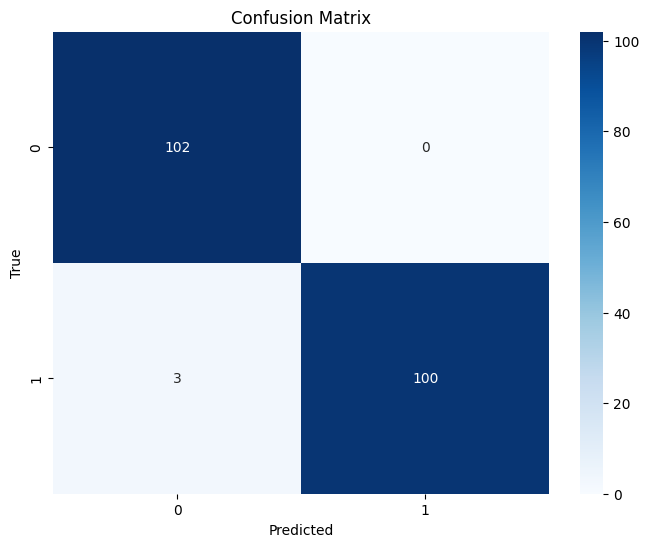

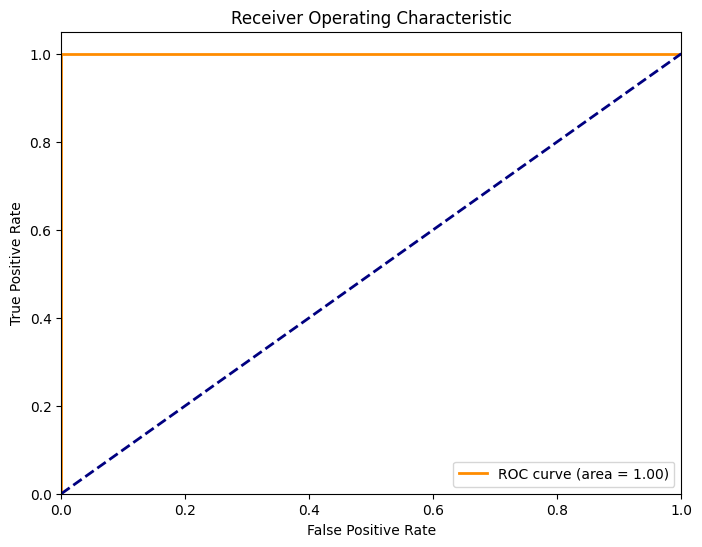

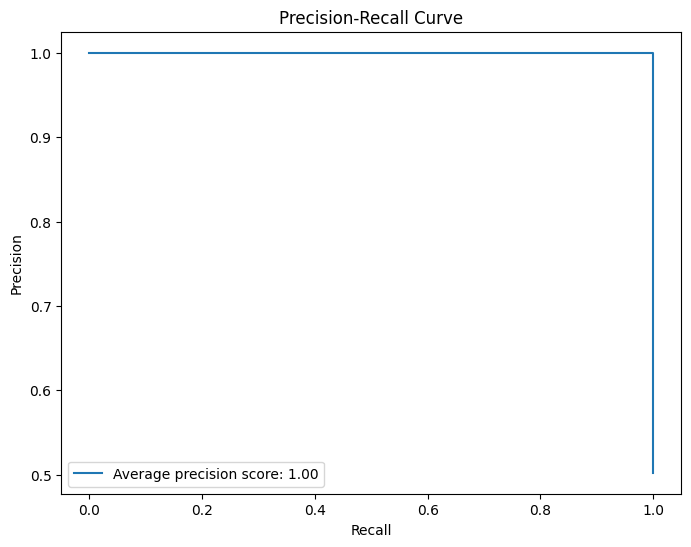

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


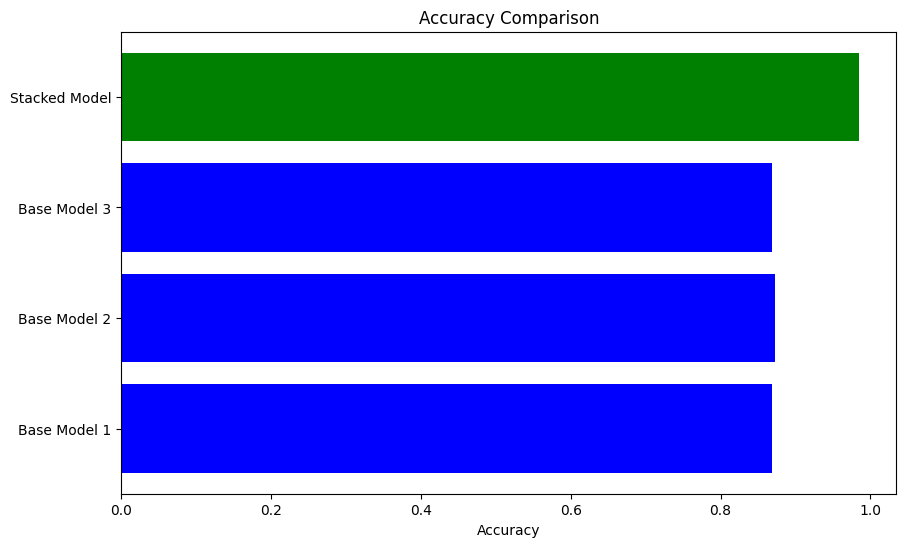

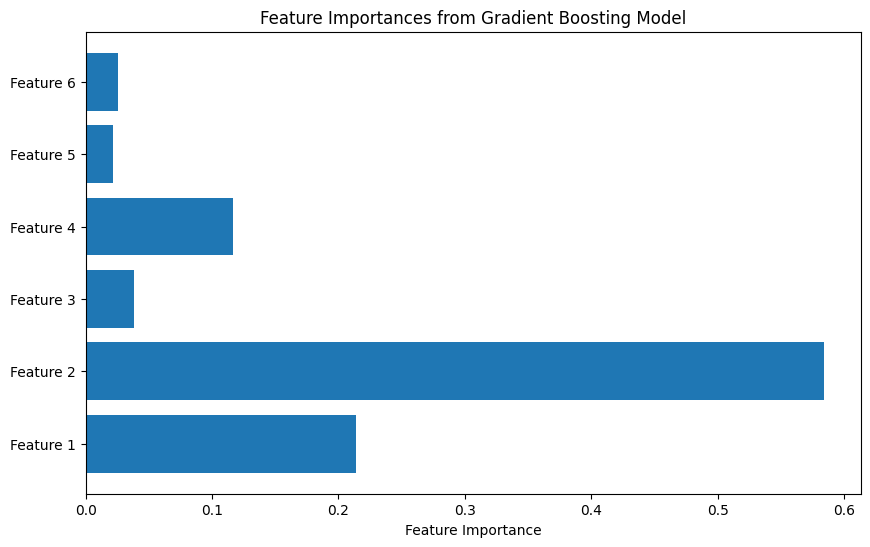

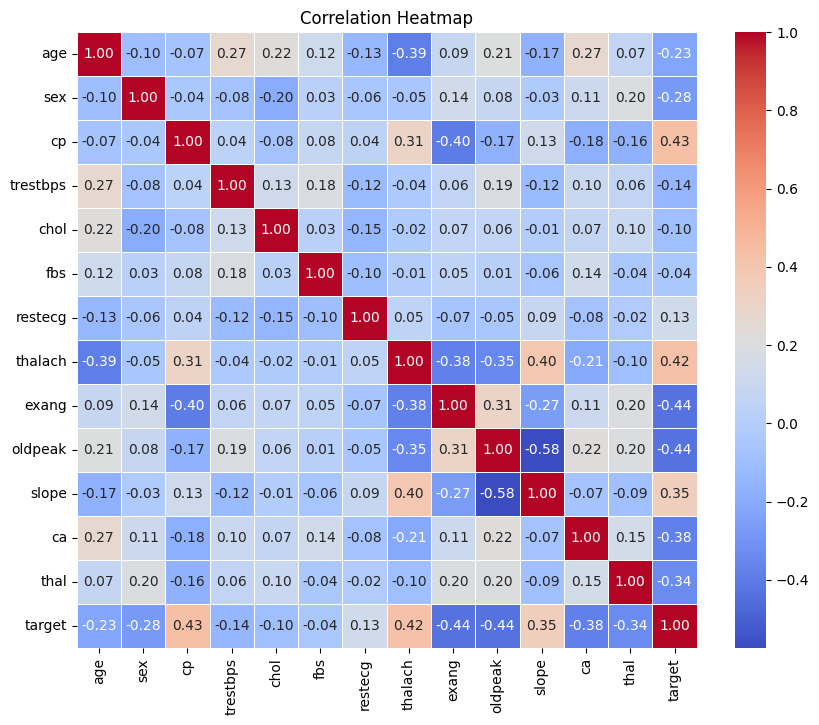

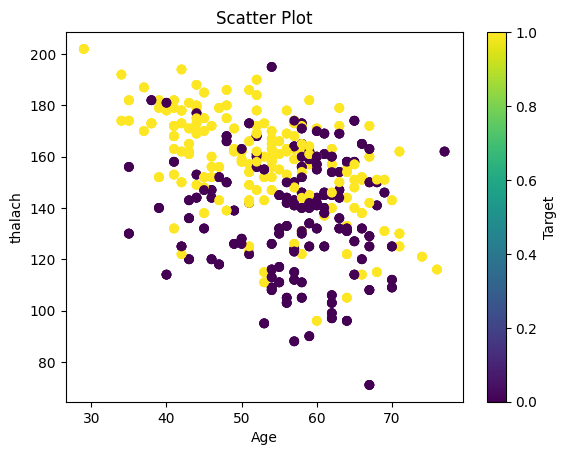

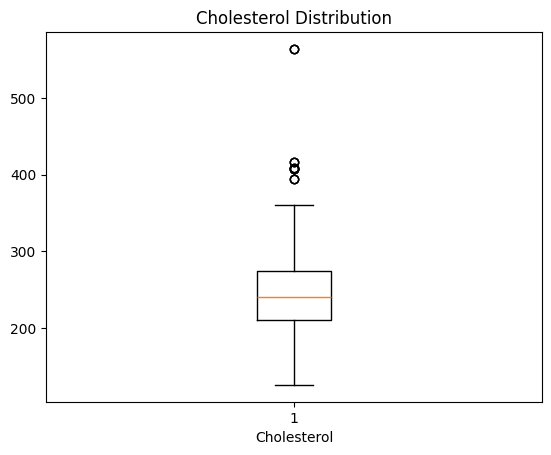

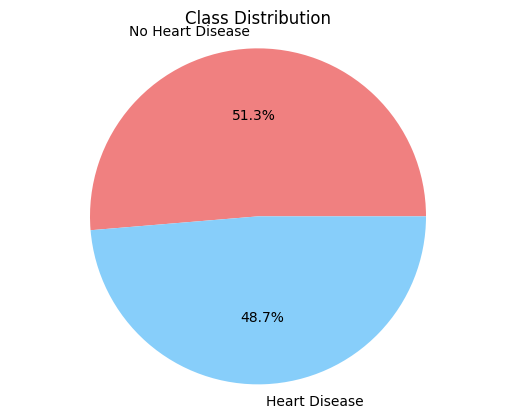

<ipython-input-3-8bf6d9bb4a5f>:87: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['age'], shade=True, color="r")


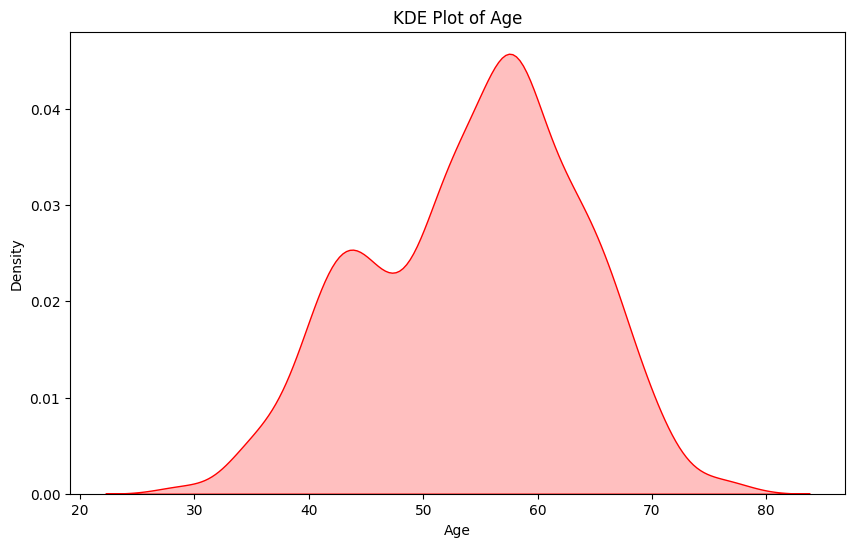

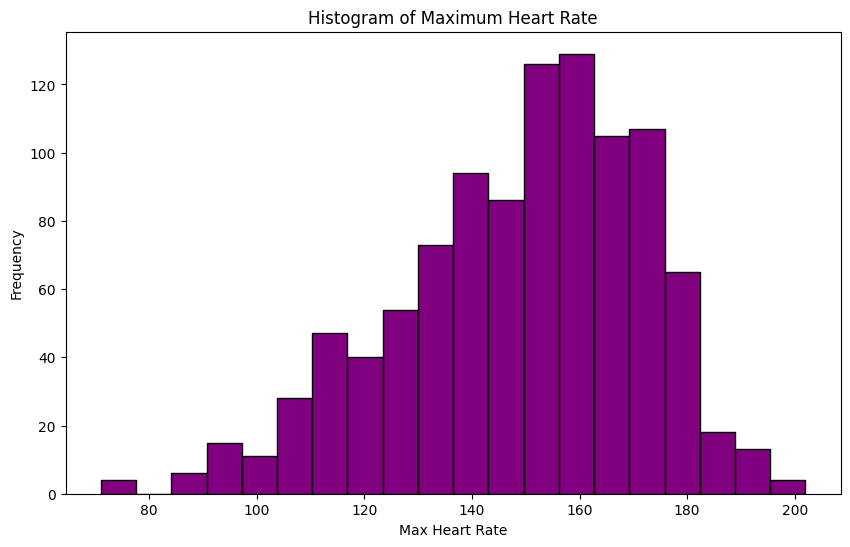

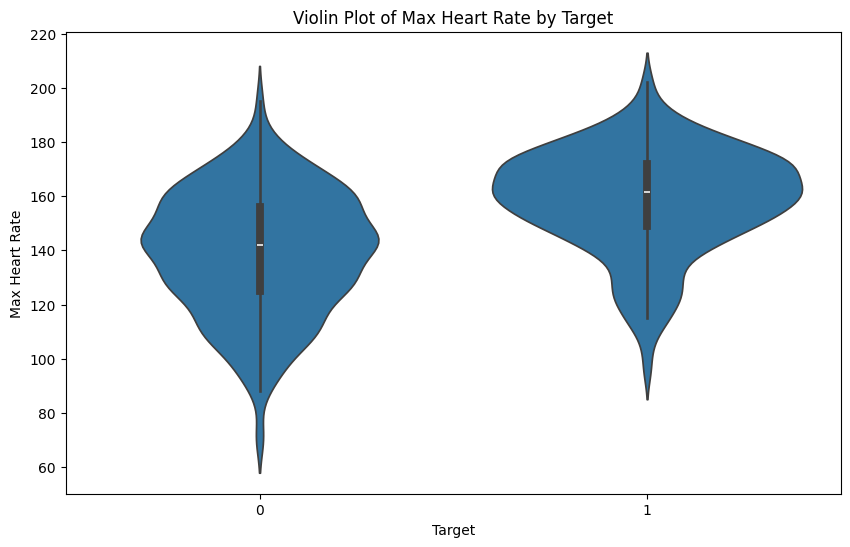

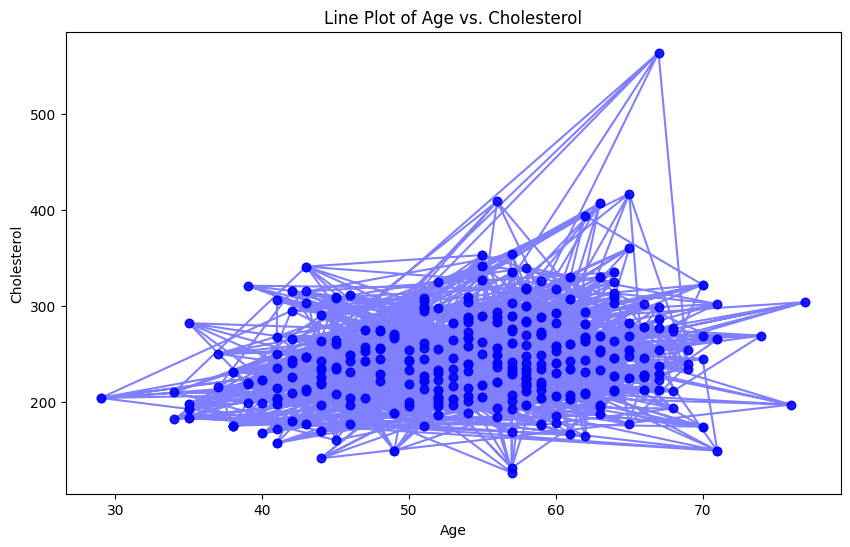

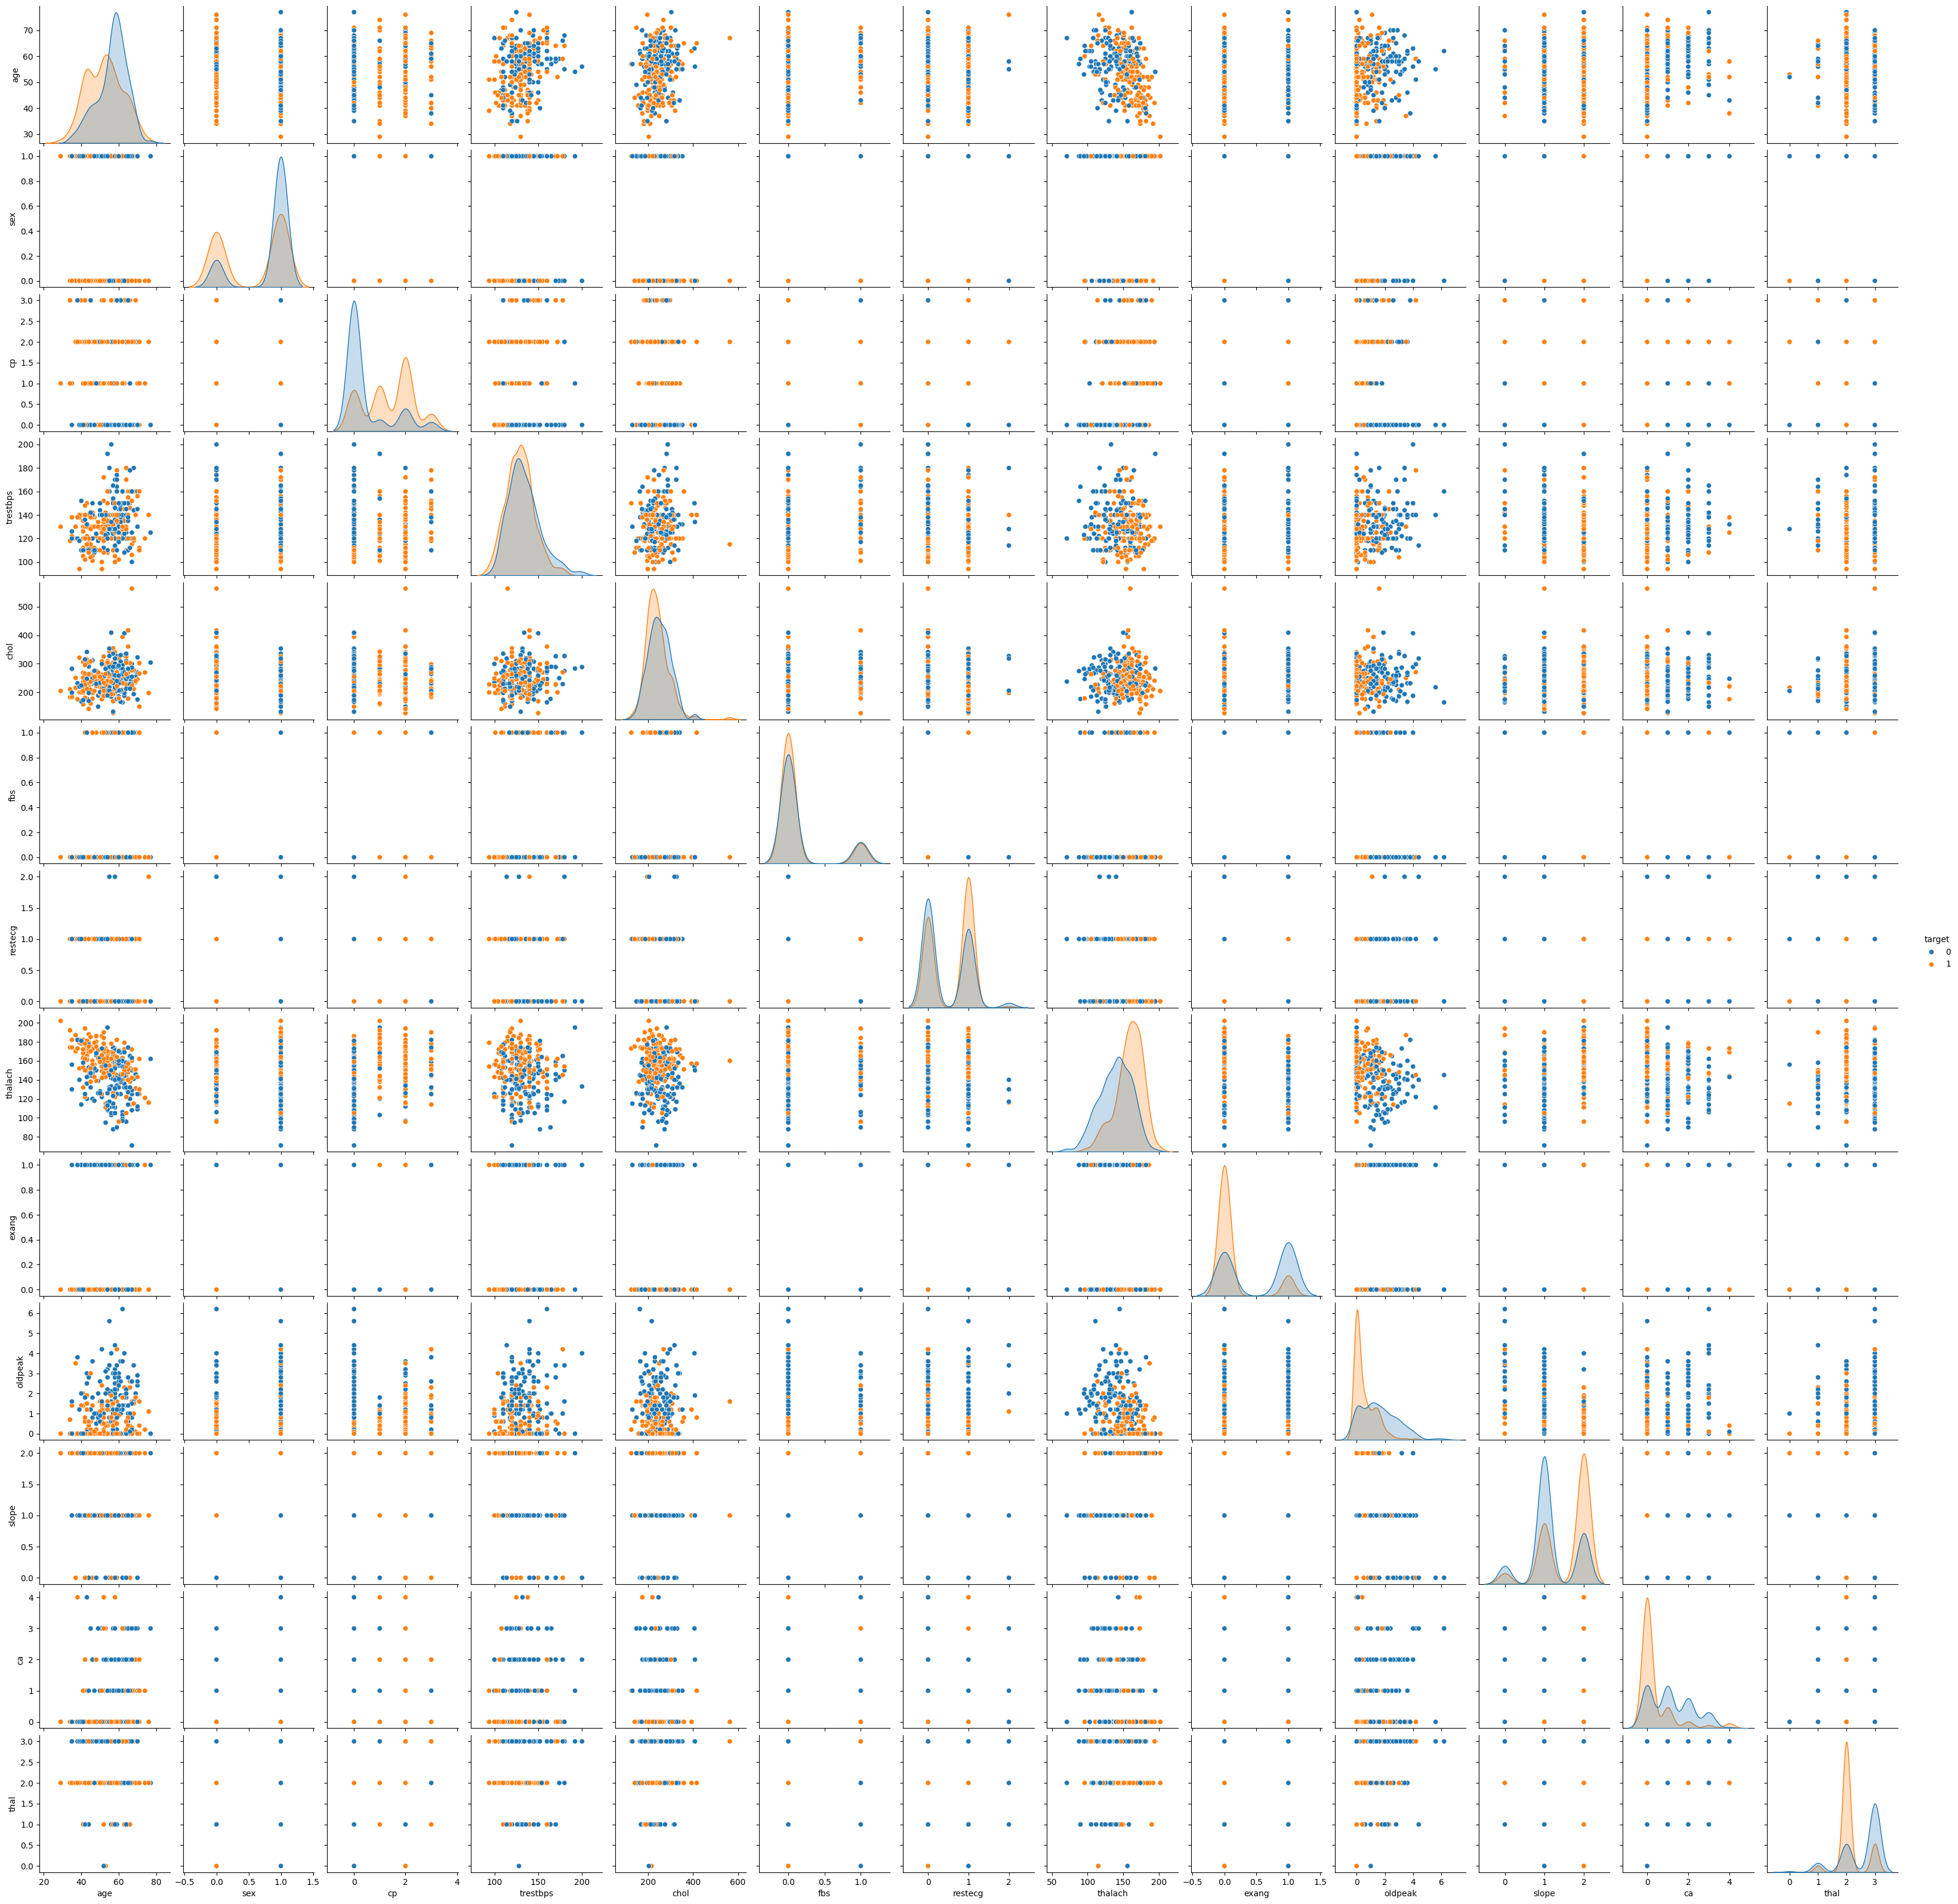

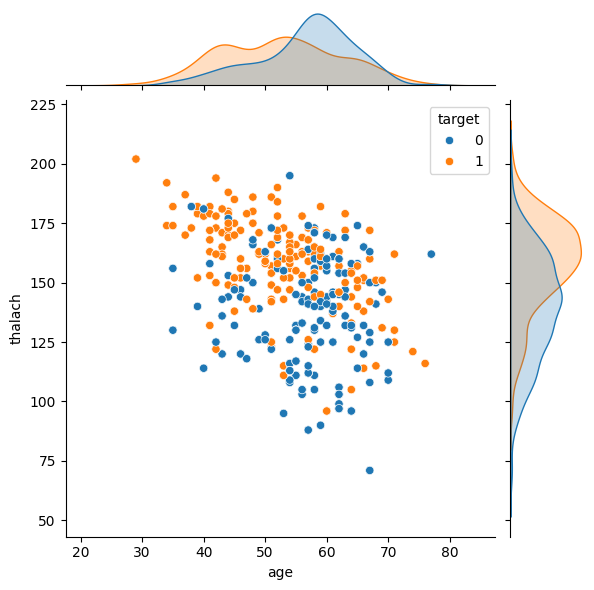

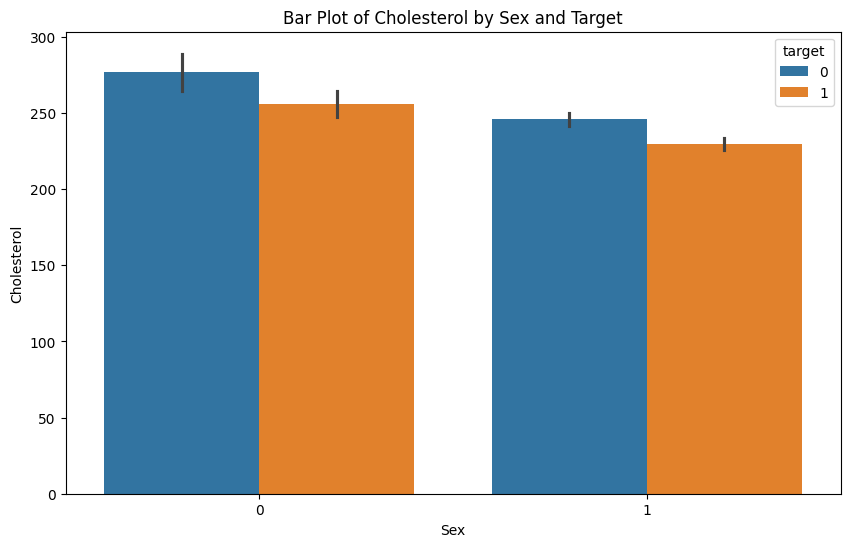

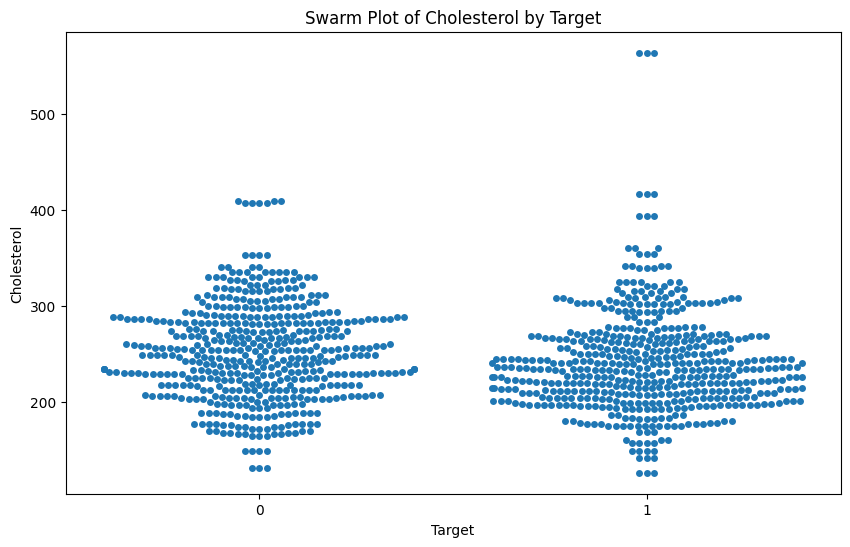

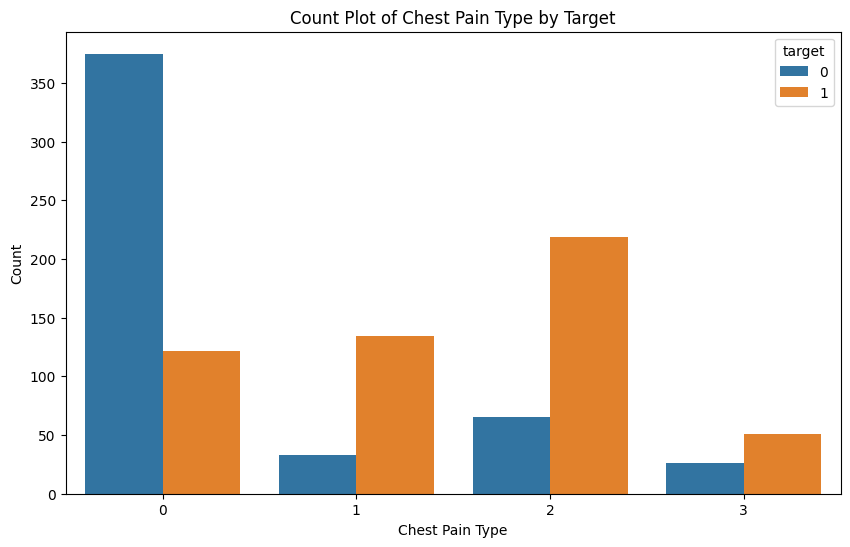

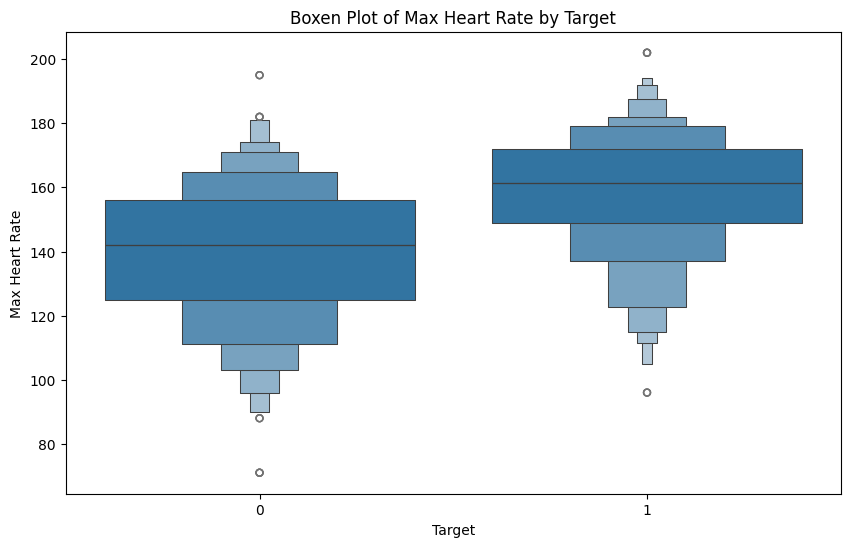

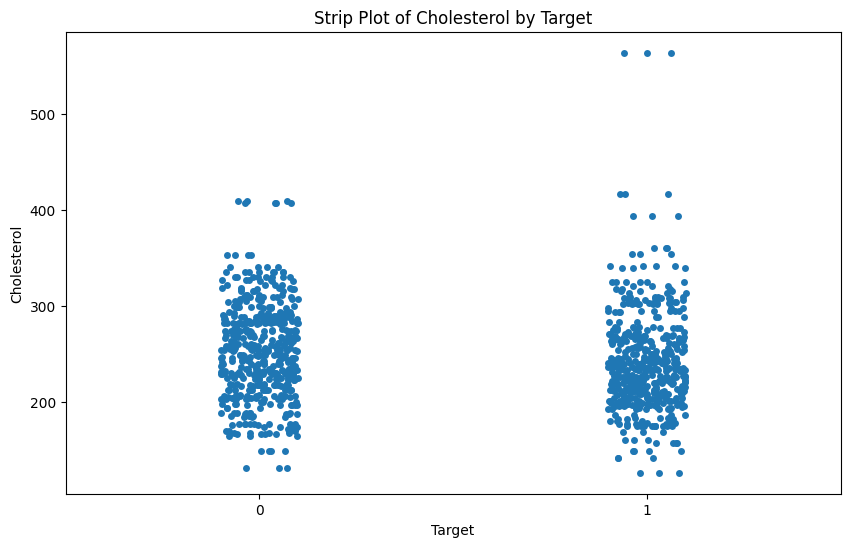

<ipython-input-3-8bf6d9bb4a5f>:183: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['age'], shade=True, color="r", ax=axs[1, 1])


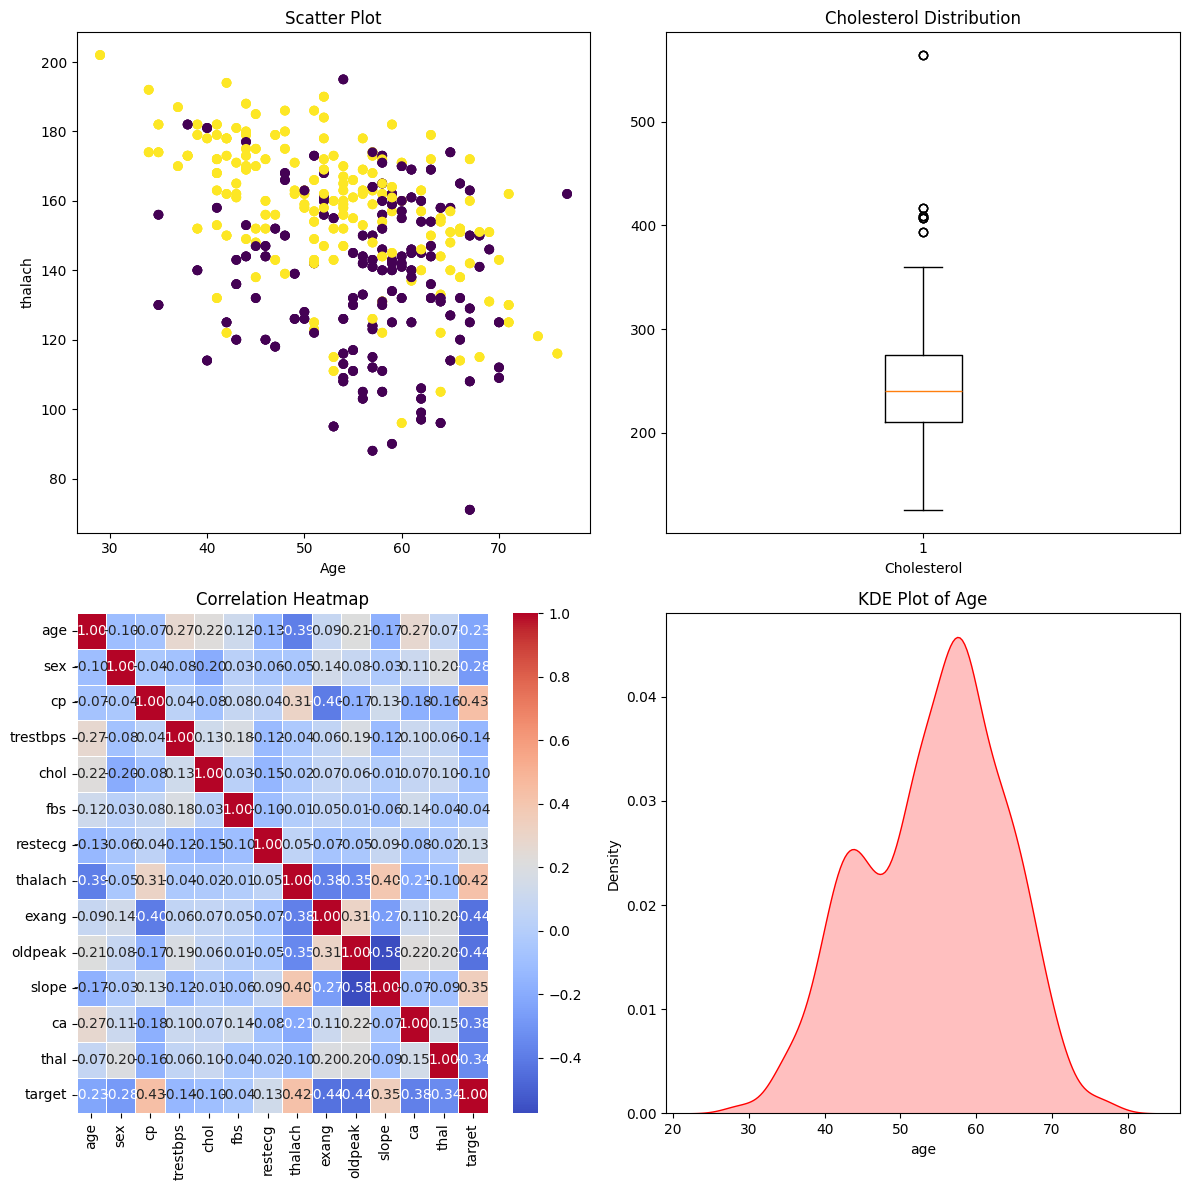

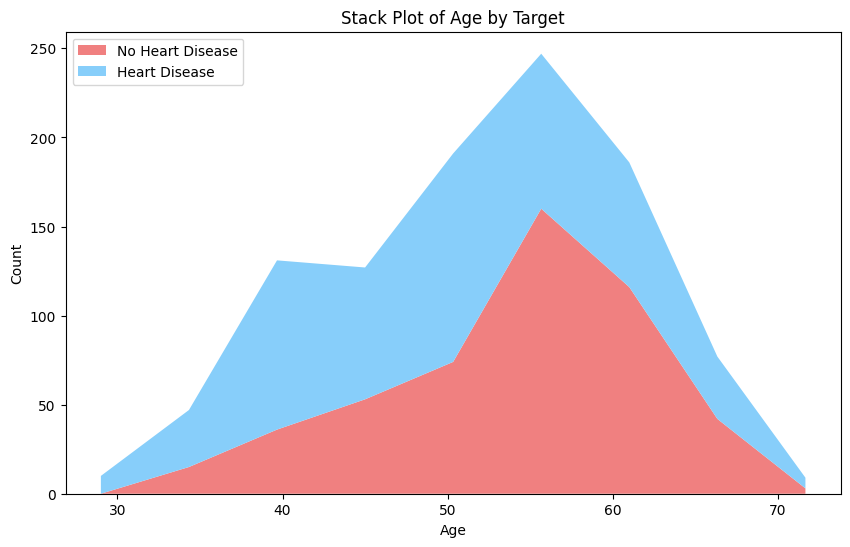

In [3]:

# Confusion Matrix
cm = confusion_matrix(y_test_second_level, final_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_second_level, second_level_model.predict_proba(first_level_predictions_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_second_level, second_level_model.predict_proba(first_level_predictions_test)[:, 1])
average_precision = average_precision_score(y_test_second_level, second_level_model.predict_proba(first_level_predictions_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.step(recall, precision, where='post', label=f'Average precision score: {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

# Accuracy Comparison Plot
base_accuracies = [accuracy_score(np.argmax(y_test, axis=1), np.argmax(model.predict(X_test), axis=1)) for model in base_models]
base_names = ['Base Model 1', 'Base Model 2', 'Base Model 3']
all_accuracies = base_accuracies + [final_accuracy]
all_names = base_names + ['Stacked Model']

plt.figure(figsize=(10, 6))
plt.barh(all_names, all_accuracies, color=['blue', 'blue', 'blue', 'green'])
plt.xlabel('Accuracy')
plt.title('Accuracy Comparison')
plt.show()

# Feature Importances (for Gradient Boosting Model)
feature_importances = second_level_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center')
plt.yticks(range(len(feature_importances)), ['Feature ' + str(i+1) for i in range(len(feature_importances))])
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Gradient Boosting Model')
plt.show()

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

# Scatter Plot
plt.figure()
plt.scatter(data['age'], data['thalach'], c=data['target'], cmap='viridis')
plt.xlabel('Age')
plt.ylabel('thalach')
plt.title('Scatter Plot')
plt.colorbar(label='Target')
plt.show()

# Box Plot
plt.figure()
plt.boxplot(data['chol'])
plt.xlabel('Cholesterol')
plt.title('Cholesterol Distribution')
plt.show()

# Pie Chart
plt.figure()
plt.pie(data['target'].value_counts(), labels=['No Heart Disease', 'Heart Disease'], autopct='%1.1f%%', colors=['lightcoral', 'lightskyblue'])
plt.title('Class Distribution')
plt.axis('equal')
plt.show()

# KDE Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(data['age'], shade=True, color="r")
plt.title('KDE Plot of Age')
plt.xlabel('Age')
plt.show()

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(data['thalach'], bins=20, color='purple', edgecolor='black')
plt.title('Histogram of Maximum Heart Rate')
plt.xlabel('Max Heart Rate')
plt.ylabel('Frequency')
plt.show()

# Violin Plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='target', y='thalach', data=data)
plt.title('Violin Plot of Max Heart Rate by Target')
plt.xlabel('Target')
plt.ylabel('Max Heart Rate')
plt.show()

# Line Plot (example: age vs. cholesterol)
plt.figure(figsize=(10, 6))
plt.plot(data['age'], data['chol'], 'bo', linestyle='-', alpha=0.5)
plt.title('Line Plot of Age vs. Cholesterol')
plt.xlabel('Age')
plt.ylabel('Cholesterol')
plt.show()

# Pair Plot
sns.pairplot(data, hue='target')
plt.show()

# Joint Plot
sns.jointplot(x='age', y='thalach', data=data, kind='scatter', hue='target')
plt.show()

# Bar Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='sex', y='chol', hue='target', data=data)
plt.title('Bar Plot of Cholesterol by Sex and Target')
plt.xlabel('Sex')
plt.ylabel('Cholesterol')
plt.show()

# Swarm Plot
plt.figure(figsize=(10, 6))
sns.swarmplot(x='target', y='chol', data=data)
plt.title('Swarm Plot of Cholesterol by Target')
plt.xlabel('Target')
plt.ylabel('Cholesterol')
plt.show()

# Count Plot
plt.figure(figsize=(10, 6))
sns.countplot(x='cp', hue='target', data=data)
plt.title('Count Plot of Chest Pain Type by Target')
plt.xlabel('Chest Pain Type')
plt.ylabel('Count')
plt.show()

# Boxen Plot
plt.figure(figsize=(10, 6))
sns.boxenplot(x='target', y='thalach', data=data)
plt.title('Boxen Plot of Max Heart Rate by Target')
plt.xlabel('Target')
plt.ylabel('Max Heart Rate')
plt.show()

# Strip Plot
plt.figure(figsize=(10, 6))
sns.stripplot(x='target', y='chol', data=data, jitter=True)
plt.title('Strip Plot of Cholesterol by Target')
plt.xlabel('Target')
plt.ylabel('Cholesterol')
plt.show()

# Grid Plot
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Scatter Plot
axs[0, 0].scatter(data['age'], data['thalach'], c=data['target'], cmap='viridis')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('thalach')
axs[0, 0].set_title('Scatter Plot')

# Box Plot
axs[0, 1].boxplot(data['chol'])
axs[0, 1].set_xlabel('Cholesterol')
axs[0, 1].set_title('Cholesterol Distribution')

# Heatmap
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5, ax=axs[1, 0])
axs[1, 0].set_title('Correlation Heatmap')

# KDE Plot
sns.kdeplot(data['age'], shade=True, color="r", ax=axs[1, 1])
axs[1, 1].set_title('KDE Plot of Age')

plt.tight_layout()
plt.show()

# Stack Plot (using binned data)
age_bins = np.linspace(data['age'].min(), data['age'].max(), 10)
no_disease_counts, _ = np.histogram(data[data['target'] == 0]['age'], bins=age_bins)
disease_counts, _ = np.histogram(data[data['target'] == 1]['age'], bins=age_bins)

plt.figure(figsize=(10, 6))
plt.stackplot(age_bins[:-1], no_disease_counts, disease_counts, labels=['No Heart Disease', 'Heart Disease'], colors=['lightcoral', 'lightskyblue'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Stack Plot of Age by Target')
plt.legend(loc='upper left')
plt.show()
